# Train classifiers on BirdNET or Perch embeddings

This notebook shows examples of how to train simple one-layer or multi-layer fully-connected neural networks (aka multi-layer perceptron networks, MLPs) on Perch [1] and BirdNET [2], which are TensorFlow models. For a more general introduction to transfer learning tools in OpenSoundscape see the `transfer_learning.ipynb` notebook, which focuses on PyTorch (rather than Tensorflow) embedding models. 

Though BirdNET and Perch are TensorFlow models, we can still use them as feature extractors (to generate embeddings) and train shallow classifiers on top of them with PyTorch. We just won't be able to train the feature extractor weights at all. 

For this notebook, you'll need a Python environment with `tensorflow` and `tensorflow-hub` packages installed. If you want cuda gpu acceleration on a linux machine, check this [table](https://www.tensorflow.org/install/source#gpu) for the `tensorflow` and `cudnn` package versions you'll need to be compatible with your current CUDA version (you can check the cuda version on your machine by calling `nvidia-smi` from command line). Note that the `cudnn` package version might conflict with which version PyTorch wants, so we recommend creating separate Python environments for pytorch and tensorflow cuda-compatability. 

Note that in this tutorial, all classifiers are trained as multi-target (each class is predicted independently, such that any sample can have 0, 1, or >1 classes present). Most bioacoustics classification tasks are multi-target. 

## preparing your python environment
This notebook uses the [bioacoustics_model_zoo](https://github.com/kitzeslab/bioacoustics-model-zoo), so you'll want to install that repository as a package in your python environment. After installing, be sure to restart this notebook's kernel so that the model zoo is available. From command line, you can install the model zoo from github using

`pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo`

If you want a specific version (aka tag or release) of the model zoo, you can specify it after an @ symbol:

`pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo@0.11.0.dev1`


> [1] Ghani, B., T. Denton, S. Kahl, H. Klinck, T. Denton, S. Kahl, and H. Klinck. 2023. Global birdsong embeddings enable superior transfer learning for bioacoustic classification. Scientific Reports 13:22876.
>
> [2] Kahl, Stefan, et al. "BirdNET: A deep learning solution for avian diversity monitoring." Ecological Informatics 61 (2021): 101236.


## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [13]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install opensoundscape==0.12.0 ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0
  %pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo
  num_workers=0
else:
  num_workers=4

## Setup

### Import needed packages

In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_55607/4234765199.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Download and prepare training data


#### Download example files
Download a set of aquatic soundscape recordings with annotations of _Rana sierrae_ vocalizations. If you already have them, you can skip this step. 

Option 1: run the cell below

- if you get a 403 error, DataDryad suspects you are a bot. Use Option 2. 

Option 2:

- Download and unzip the `rana_sierrae_2022.zip` folder containing audio and annotations from this [public Dryad dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.9s4mw6mn3#readme)
- Move the unzipped `rana_sierrae_2022` folder into the current folder

In [3]:
# Note: the "!" preceding each line below allows us to run bash commands in a Jupyter notebook
# If you are not running this code in a notebook, input these commands into your terminal instead
!wget -O rana_sierrae_2022.zip https://datadryad.org/stash/downloads/file_stream/2722802;
!unzip rana_sierrae_2022;

--2025-02-28 12:50:59--  https://datadryad.org/stash/downloads/file_stream/2722802
Resolving datadryad.org (datadryad.org)... 44.231.126.195, 35.161.56.100, 44.236.210.21, ...
Connecting to datadryad.org (datadryad.org)|44.231.126.195|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-02-28 12:51:00 ERROR 403: Forbidden.

Archive:  rana_sierrae_2022.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  rana_sierrae_2022.ZIP
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.


#### Prepare audio data
See the train_cnn.ipynb tutorial for step-by-step walkthrough of this process, or just run the cells below to prepare a trainig set.

In [4]:
# Set the current directory to where the folder `rana_sierrae_2022` is located:
dataset_path = Path("./rana_sierrae_2022/")

# let's generate clip labels of 5s duration (to match Perch input duration) using the raven annotations
# and some utility functions from opensoundscape
from opensoundscape.annotations import BoxedAnnotations

audio_and_raven_files = pd.read_csv(f"{dataset_path}/audio_and_raven_files.csv")
# update the paths to where we have the audio and raven files stored
audio_and_raven_files["audio"] = audio_and_raven_files["audio"].apply(
    lambda x: f"{dataset_path}/{x}"
)
audio_and_raven_files["raven"] = audio_and_raven_files["raven"].apply(
    lambda x: f"{dataset_path}/{x}"
)

annotations = BoxedAnnotations.from_raven_files(
    raven_files=audio_and_raven_files["raven"],
    audio_files=audio_and_raven_files["audio"],
    annotation_column="annotation",
)
# generate labels for 5s clips, including any labels that overlap by at least 0.2 seconds
labels = annotations.clip_labels(clip_duration=3, min_label_overlap=0.2)

/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/annotations.py:302: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations_df = pd.concat(all_file_dfs).reset_index(drop=True)


#### Inspect labels

Count number of each annotation type: 

Note that the 'X' label is for when the annotator was uncertain about the identity of a call. Labels A-E denote distinct call types.

In [5]:
labels.sum()

A    585
E    154
D     61
B     22
C     91
X    120
dtype: int64

#### split into training and validation data
We'll just focus on class 'A', the call type with the most annotations. We'll randomly split the clips into training and validation data, acknowledging that this approach does not test the ability of the model to generalize. Since the samples in the training and validation sets could be adjascent 2-second audio clips, good performance could simply mean the model has memorized the training samples, and the validation set has very similar samples. 

In [6]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[["A"]])

## Train classification head on BirdNET

The BirdNET and Perch models provided in the Bioacoustics Model Zoo have a `.tf_model` attribute containing the TensorFlow inference model and a `.network` attribute containing a trainable PyTorch classification head, specifically an instance of the MLPCLassifier class. To train a custom classifier on the embeddings extracted by these models, we just need to (1) embed the training and validation samples, then (2) pass the embeddings and labels to the `.network.fit()` method. 

This is equivalent to passing the `.network` to the the `opensoundscape.ml.shallow_classifier.quick_fit()` method, so you can also experiment with generating your own classification heads (e.g. various instances of MLPClassifier) and fitting each of them on the embeddings. See the transfer learning tutorial for further examples. 

#### First, get BirdNET from the Bioacoustics Model Zoo

In [7]:
import bioacoustics_model_zoo as bmz

birdnet = bmz.BirdNET()

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir


File BirdNET_GLOBAL_6K_V2.4_Labels_af.txt already exists; skipping download.
downloading model from URL...
File BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite already exists; skipping download.


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:628: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/SML161/mini

#### Second, generate embeddings on the training and validation samples

In general, generating embeddings will take a bit of time (because it requires loading, preprocessing, and embedding samples) but training shallow classifiers will be fast. 

In [8]:
emb_train = birdnet.embed(labels_train, return_dfs=False, batch_size=128, num_workers=0)
emb_val = birdnet.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

#### Third, fit the shallow classifier on the desired classes

In [9]:
# We want to train the classifier on the 'A' class here, corresponding to the primary R. sierrae call type.
# Let's replace fc output layer with 1-output layer for class 'A'
classes = ["A"]
birdnet.change_classes(classes)

# fit the classification head with embeddings and labels
birdnet.network.fit(emb_train, labels_train.values, emb_val, labels_val.values)

Epoch 100/1000, Loss: 0.3305512070655823, Val Loss: 0.3374575674533844
val AU ROC: 0.927
val MAP: 0.823
Epoch 200/1000, Loss: 0.2898257076740265, Val Loss: 0.3212742805480957
val AU ROC: 0.929
val MAP: 0.828
Epoch 300/1000, Loss: 0.26516640186309814, Val Loss: 0.32037028670310974
val AU ROC: 0.927
val MAP: 0.827
Epoch 400/1000, Loss: 0.24709737300872803, Val Loss: 0.32408201694488525
val AU ROC: 0.923
val MAP: 0.821
Epoch 500/1000, Loss: 0.23241738975048065, Val Loss: 0.3291391432285309
val AU ROC: 0.919
val MAP: 0.818
Epoch 600/1000, Loss: 0.21972902119159698, Val Loss: 0.3344647288322449
val AU ROC: 0.915
val MAP: 0.813
Epoch 700/1000, Loss: 0.20837059617042542, Val Loss: 0.33978578448295593
val AU ROC: 0.911
val MAP: 0.810
Epoch 800/1000, Loss: 0.19800180196762085, Val Loss: 0.3450978100299835
val AU ROC: 0.909
val MAP: 0.807
Epoch 900/1000, Loss: 0.1884281188249588, Val Loss: 0.3504630923271179
val AU ROC: 0.906
val MAP: 0.804
Epoch 1000/1000, Loss: 0.17952516674995422, Val Loss: 0

#### Fourth, evaluate the classifier on the validation set

In [10]:
# make predictions by passing the embeddings through the classifier
preds = birdnet.network(torch.tensor(emb_val)).detach()
# calculate the area under the ROC score
roc_auc_score(labels_val.values, preds, average=None)

0.904199372056515

to visualize the performance, let's plot histograms of classifier logit scores for positive and negative samples

it shows that precision is ok for scores above 2 (few negatives get high scores), but recall is only moderate (many positive samples get low scores)

/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


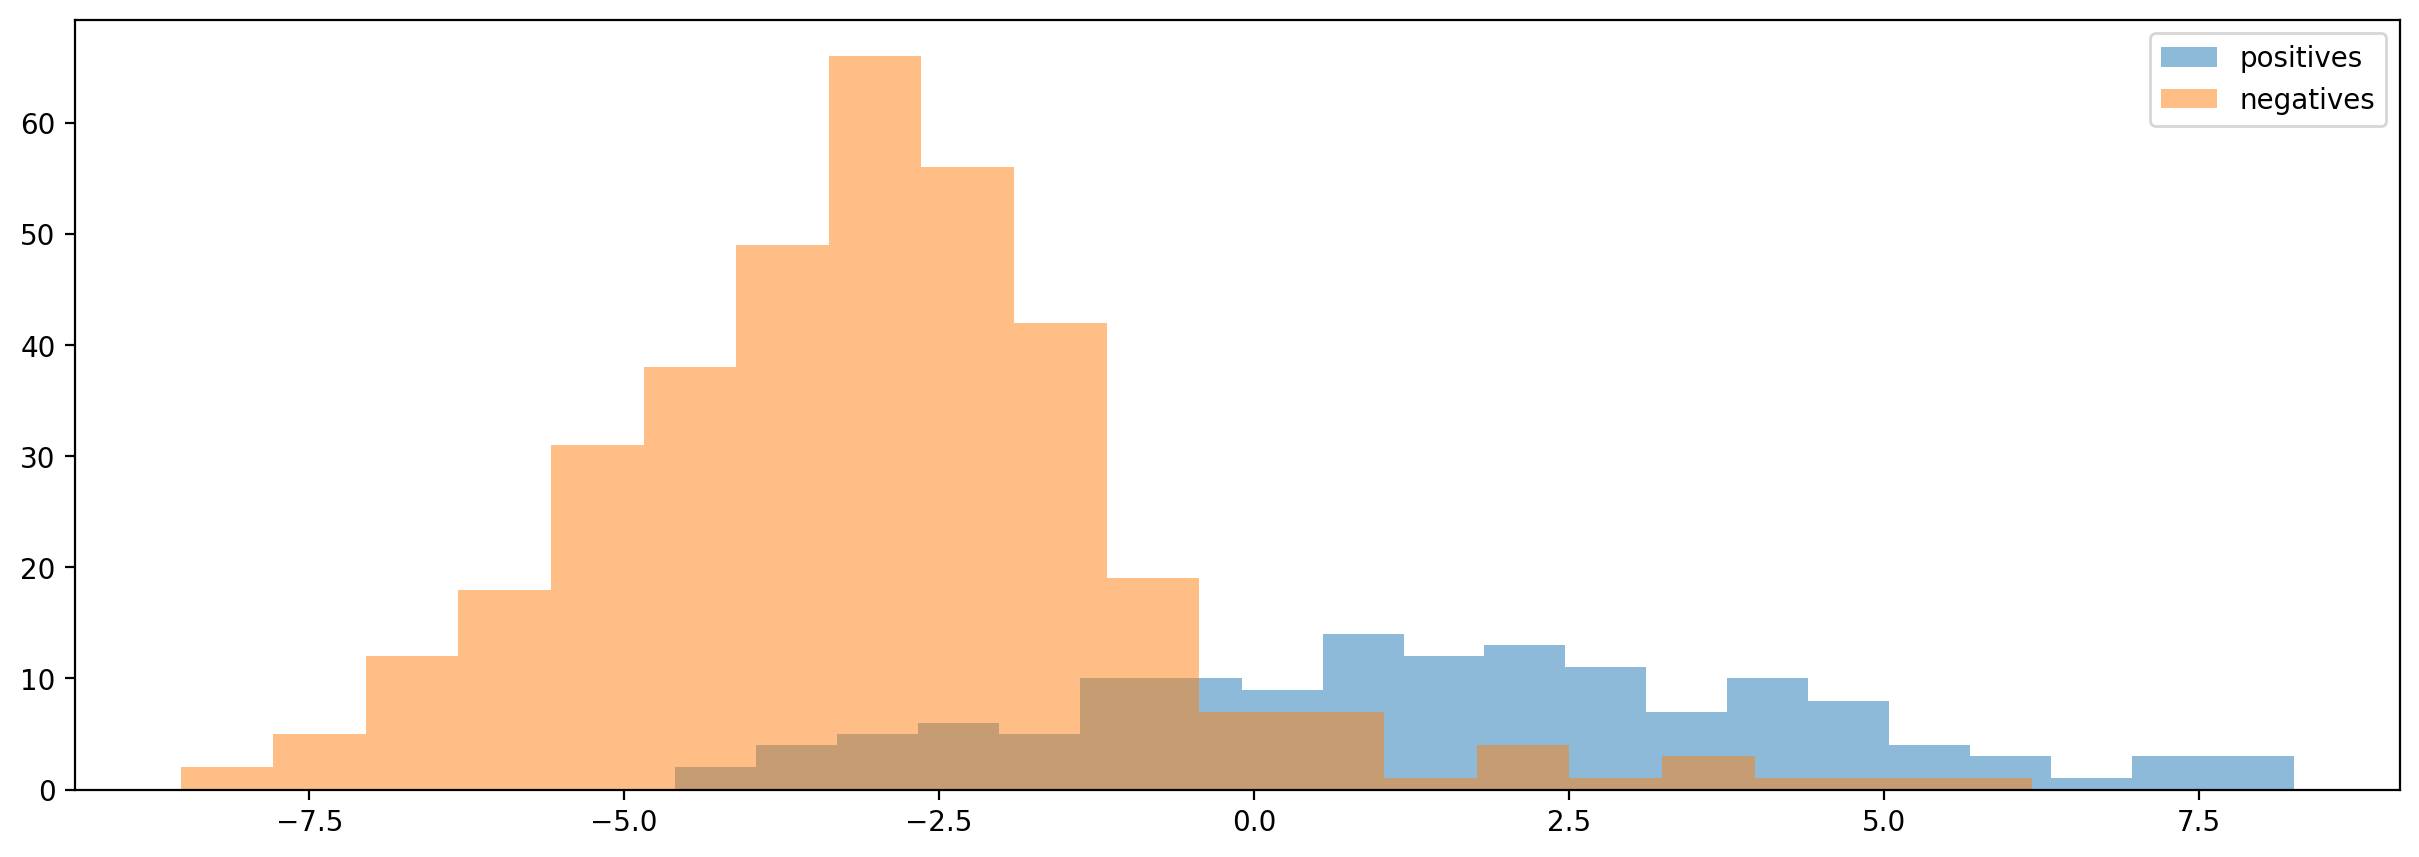

In [11]:
preds = preds.detach().numpy()
plt.hist(preds[labels_val == True], bins=20, alpha=0.5, label="positives")
plt.hist(preds[labels_val == False], bins=20, alpha=0.5, label="negatives")
plt.legend()

### simplifying training into a single function call

We can use the .train() function to combine these steps into one line of code: the function first creates embeddings, then fits the shallow classifier using the embeddings and the labels. It also reports performance on the validation set. This function is designed to look very similar to the Opensoundscape.CNN.train() method, but note that it is doing something different: it begins by creating embeddings using the pre-trained model, and only trains the classification head, not the entire model architecture (the feature extraction layers remain unchanged). 

The advantage of taking each step separately (as shown above) is that once we create the embeddings, we can rapidly try fitting different shallow classifiers.

In [14]:
birdnet.change_classes(classes)
birdnet.train(
    train_df=labels_train,
    validation_df=labels_val,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
    steps=1000,
)

Embedding the training samples without augmentation


  0%|          | 0/12 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

Embedding the validation samples


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

Fitting the classifier
Epoch 100/1000, Loss: 0.32648995518684387, Val Loss: 0.33605921268463135
val AU ROC: 0.924
val MAP: 0.820
Epoch 200/1000, Loss: 0.28611692786216736, Val Loss: 0.32104530930519104
val AU ROC: 0.927
val MAP: 0.827
Epoch 300/1000, Loss: 0.261658251285553, Val Loss: 0.3209640085697174
val AU ROC: 0.925
val MAP: 0.823


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch 400/1000, Loss: 0.24371474981307983, Val Loss: 0.3252239525318146
val AU ROC: 0.921
val MAP: 0.819
Epoch 500/1000, Loss: 0.22906774282455444, Val Loss: 0.33060380816459656
val AU ROC: 0.917
val MAP: 0.816
Epoch 600/1000, Loss: 0.21635054051876068, Val Loss: 0.33612900972366333
val AU ROC: 0.913
val MAP: 0.812
Epoch 700/1000, Loss: 0.20493458211421967, Val Loss: 0.3416011929512024
val AU ROC: 0.910
val MAP: 0.809
Epoch 800/1000, Loss: 0.1945018470287323, Val Loss: 0.3470570147037506
val AU ROC: 0.907
val MAP: 0.806
Epoch 900/1000, Loss: 0.1848701536655426, Val Loss: 0.3525783121585846
val AU ROC: 0.905
val MAP: 0.803
Epoch 1000/1000, Loss: 0.1759210079908371, Val Loss: 0.35823631286621094
val AU ROC: 0.903
val MAP: 0.801
Training complete


### adjusting the shallow classifier architecture
By default, we are training a single fully-connected neural network layer to map from the embeddings (feature vectors) to the class predictions, which is equivalent to logistic regression. We can easily modify the structure of the shallow classifier to a multi-layer network. For instance, let's make a 2-layer artificial neural network with a hidden layer of size (100,):

In [15]:
# replace the classification head with a 2-layer MLP (2 fully-connected layers)
birdnet.initialize_custom_classifier(hidden_layer_sizes=[100], classes=classes)

# train the classifier in one step: this function first creates embeddings, then fits the classification head
birdnet.train(
    train_df=labels_train,
    validation_df=labels_val,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
    steps=1000,
)

Embedding the training samples without augmentation


  0%|          | 0/12 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

Embedding the validation samples


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

Fitting the classifier


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch 100/1000, Loss: 0.20317335426807404, Val Loss: 0.3276416063308716
val AU ROC: 0.917
val MAP: 0.812
Epoch 200/1000, Loss: 0.08771011233329773, Val Loss: 0.41441991925239563
val AU ROC: 0.900
val MAP: 0.786
Epoch 300/1000, Loss: 0.03732352703809738, Val Loss: 0.5476881861686707
val AU ROC: 0.891
val MAP: 0.774
Epoch 400/1000, Loss: 0.017772164195775986, Val Loss: 0.676210343837738
val AU ROC: 0.885
val MAP: 0.764
Epoch 500/1000, Loss: 0.009681718423962593, Val Loss: 0.7844258546829224
val AU ROC: 0.881
val MAP: 0.759
Epoch 600/1000, Loss: 0.005957894027233124, Val Loss: 0.8703551888465881
val AU ROC: 0.879
val MAP: 0.756
Epoch 700/1000, Loss: 0.003997490741312504, Val Loss: 0.9404857754707336
val AU ROC: 0.878
val MAP: 0.753
Epoch 800/1000, Loss: 0.0028538918122649193, Val Loss: 0.9995662569999695
val AU ROC: 0.877
val MAP: 0.752
Epoch 900/1000, Loss: 0.002132176188752055, Val Loss: 1.0502324104309082
val AU ROC: 0.876
val MAP: 0.752
Epoch 1000/1000, Loss: 0.0016484222142025828, Va

when we evaluate, we see that the performance of our two-layer classificaiton head on the validation set is slightly _worse_ than we got with a 1-layer classification head. This indicates that the two-layer model was over-parameterized, and was able to over-fit to the training data leading to worse generalization to the validation set. 

auc roc score: 0.8759419152276294


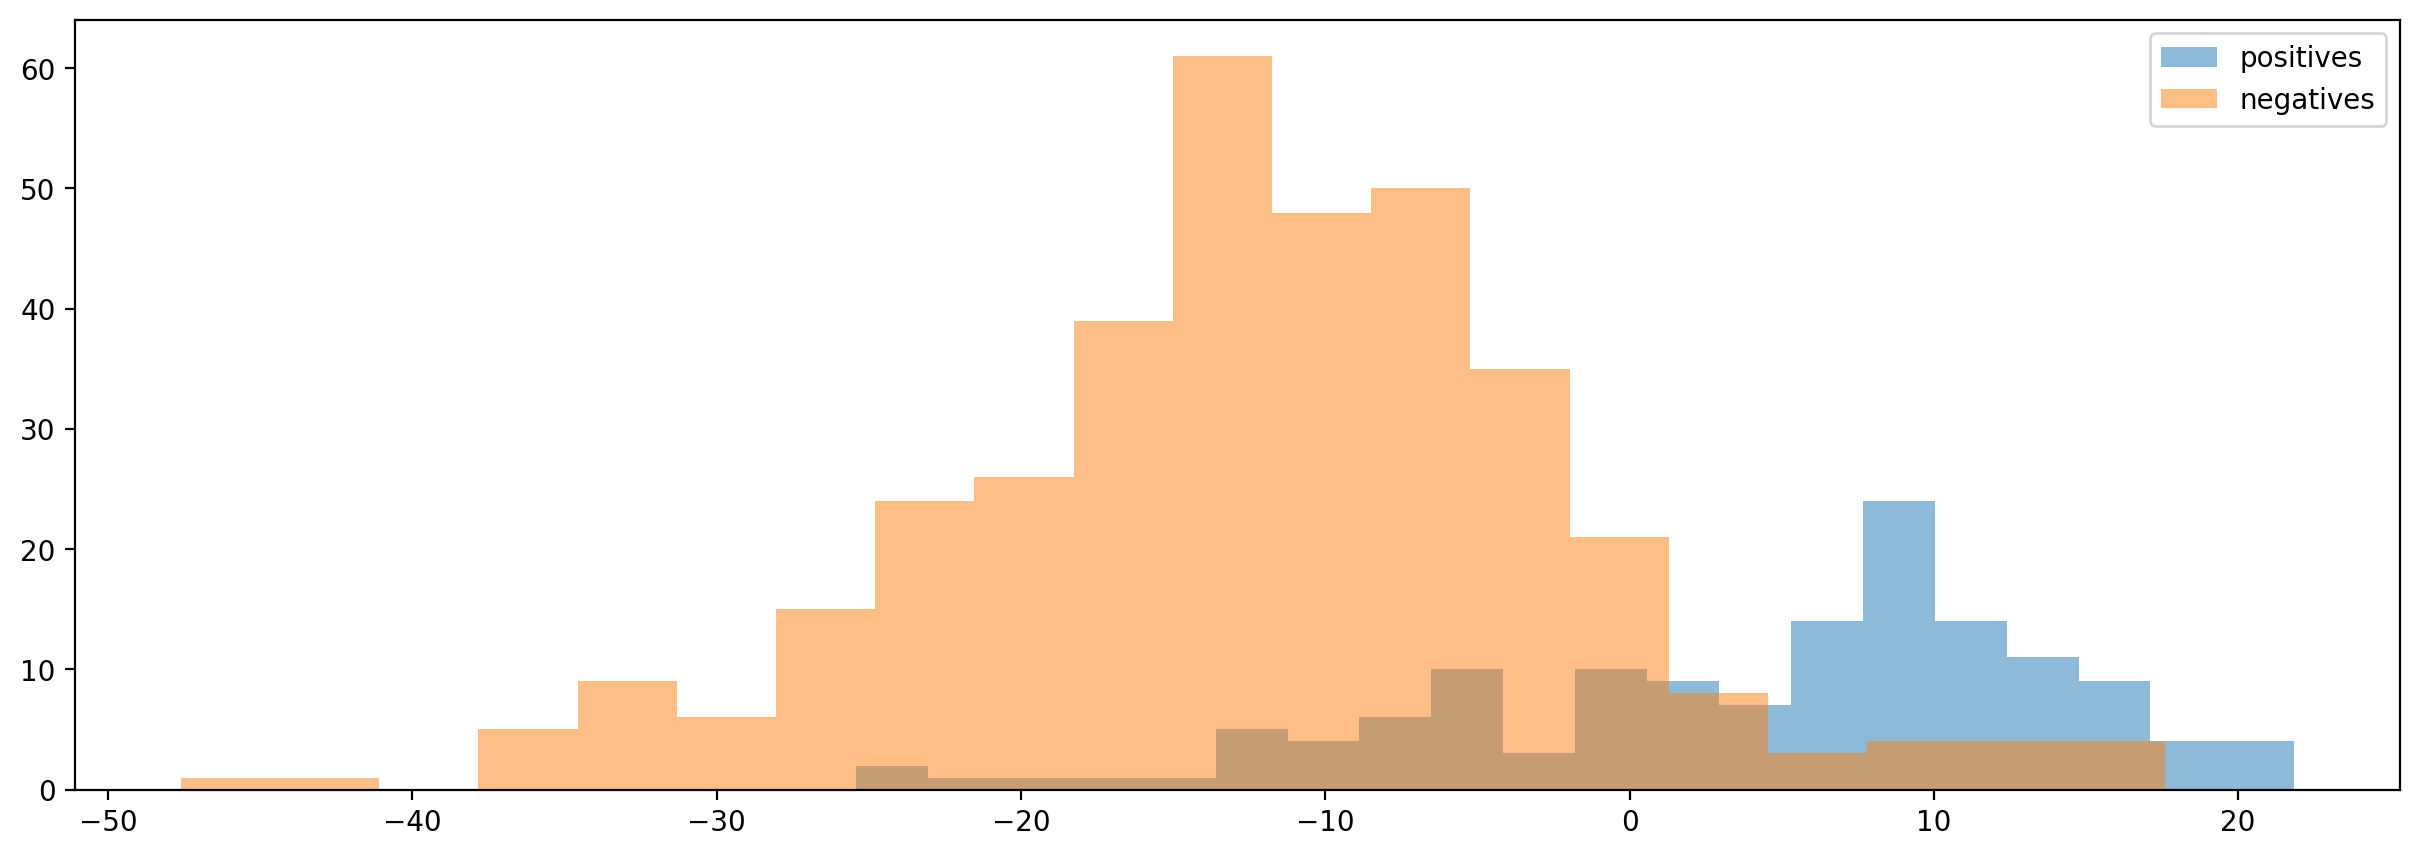

In [16]:
# make predictions by passing the embeddings through the classifier
preds = birdnet.network(torch.tensor(emb_val)).detach()
# calculate the area under the ROC score
print(f"auc roc score: {roc_auc_score(labels_val.values, preds, average=None)}")

# plot histograms
preds = preds.detach().numpy()
plt.hist(preds[labels_val == True], bins=20, alpha=0.5, label="positives")
plt.hist(preds[labels_val == False], bins=20, alpha=0.5, label="negatives")
plt.legend()

### including variants of the training samples using augmentation
Augmentation is a powerful technique for avoiding over-fitting and helping machine learning models generalize. The .predict() function gives us an option to perform stochastic augmentations of the training samples, thereby creating variations of the embeddings to increase the effective size of our training data. We use the `n_augmentation_variants` parameter to choose the number of variations: by default this parameter is 0 and no augmentation is performed. Here we choose to create 2 variations of each training sample using augmentation - in practice, it may be helpful to create 8 or more variations of each training sample, but note that the time to create the embeddings will be proportional to the number of variations you create. 

In [17]:
# revert to a 1-layer classification head
birdnet.initialize_custom_classifier(hidden_layer_sizes=[], classes=classes)
birdnet.train(
    train_df=labels_train,
    validation_df=labels_val,
    n_augmentation_variants=2,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
    steps=1000,
)

Embedding the training samples 2 times with stochastic augmentation


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

Embedding the validation samples


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

Fitting the classifier
Epoch 100/1000, Loss: 0.5135788917541504, Val Loss: 0.3661726713180542
val AU ROC: 0.907
val MAP: 0.797


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch 200/1000, Loss: 0.4875386655330658, Val Loss: 0.35220053791999817
val AU ROC: 0.905
val MAP: 0.798
Epoch 300/1000, Loss: 0.4734073281288147, Val Loss: 0.35433337092399597
val AU ROC: 0.902
val MAP: 0.800
Epoch 400/1000, Loss: 0.4627768397331238, Val Loss: 0.35949981212615967
val AU ROC: 0.899
val MAP: 0.798
Epoch 500/1000, Loss: 0.45382460951805115, Val Loss: 0.3673207759857178
val AU ROC: 0.896
val MAP: 0.796
Epoch 600/1000, Loss: 0.44590261578559875, Val Loss: 0.37762895226478577
val AU ROC: 0.893
val MAP: 0.793
Epoch 700/1000, Loss: 0.4387069642543793, Val Loss: 0.38982853293418884
val AU ROC: 0.889
val MAP: 0.788
Epoch 800/1000, Loss: 0.4320663809776306, Val Loss: 0.4031923711299896
val AU ROC: 0.884
val MAP: 0.781
Epoch 900/1000, Loss: 0.4258716404438019, Val Loss: 0.4171155095100403
val AU ROC: 0.880
val MAP: 0.776
Epoch 1000/1000, Loss: 0.420047402381897, Val Loss: 0.4312058091163635
val AU ROC: 0.876
val MAP: 0.770
Training complete


### Saving and loading fine-tuned models
We use the BirdNET.save(path) and BirdNET.load(path) functions to save and load models that include our custom classification heads. 

In [18]:
birdnet.save("./saved_custom_birdnet.model")

In [19]:
# reload the saved model later, perhaps in a different script or notebook:
loaded_model = bmz.BirdNET.load("./saved_custom_birdnet.model")

# use the model to make predictions on a dataframe or on a list of audio files
preds = loaded_model.predict(labels_val.head())

File BirdNET_GLOBAL_6K_V2.4_Labels_af.txt already exists; skipping download.
downloading model from URL...
File BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite already exists; skipping download.


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:628: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/SML161/mini

  0%|          | 0/5 [00:00<?, ?it/s]

## Train shallow classifier on Perch embeddings

Training classifiers on Perch works the same way!

Since Perch uses 5 second audio clips as inputs, we'll first re-generate clip labels for 5 second audio segments from the annotated _Rana sierrae_ dataset. 

As before, well just work on the 'A' type call for this example

As with BirdNET (see examples above): 

- our `perch` model object with the custom classification head (which is an instance of the Perch class) can be saved with `perch.save(path)` and loaded with `reloaded_model=Perch.load(path)`.

- we could perform the embedding and classifier fitting steps separately using `perch.embed(labels_val,...)` to create embeddings, then fit with `perch.network.fit(emb_train, labels_train.values, emb_val, labels_val.values)`

In [20]:
labels = annotations.clip_labels(clip_duration=5, min_label_overlap=0.2)
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[["A"]])

#### Step 1: Get the Perch model from the Biaocoustics Model Zoo

In [21]:
perch = bmz.Perch()

/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:628: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/SML161/mini

#### Step 2: Train the shallow classifier on embeddings from the BirdNET pre-trained model

We set up a 2-layer classification head (see details above) by running `initialize_custom_classifier` with one hidden layer.

We also create 2  variants of each training sample with stochastic augmentation by setting `n_augmentation_variants=2`

In [22]:
# define classes for your custom classifier
perch.change_classes(classes)

# replace the default 1-layer classification head with a 2-layer MLP (2 fully-connected layers)
perch.initialize_custom_classifier(hidden_layer_sizes=[100], classes=classes)

# train the classifier in one step: this function first creates embeddings, then fits the classification head
perch.train(
    train_df=labels_train,
    validation_df=labels_val,
    n_augmentation_variants=2,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
    steps=1000,
)

Embedding the training samples 2 times with stochastic augmentation


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

Embedding the validation samples


  0%|          | 0/3 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

Fitting the classifier


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch 100/1000, Loss: 0.5316789150238037, Val Loss: 0.4148135483264923
val AU ROC: 0.896
val MAP: 0.861
Epoch 200/1000, Loss: 0.43417346477508545, Val Loss: 0.5465565919876099
val AU ROC: 0.862
val MAP: 0.821
Epoch 300/1000, Loss: 0.37461817264556885, Val Loss: 0.6803321242332458
val AU ROC: 0.852
val MAP: 0.806
Epoch 400/1000, Loss: 0.3334544599056244, Val Loss: 0.766981840133667
val AU ROC: 0.851
val MAP: 0.807
Epoch 500/1000, Loss: 0.3015865385532379, Val Loss: 0.8464377522468567
val AU ROC: 0.851
val MAP: 0.805
Epoch 600/1000, Loss: 0.2750724256038666, Val Loss: 0.9261505603790283
val AU ROC: 0.848
val MAP: 0.804
Epoch 700/1000, Loss: 0.2510787546634674, Val Loss: 1.0035614967346191
val AU ROC: 0.847
val MAP: 0.800
Epoch 800/1000, Loss: 0.23020820319652557, Val Loss: 1.080341100692749
val AU ROC: 0.845
val MAP: 0.798
Epoch 900/1000, Loss: 0.21010051667690277, Val Loss: 1.1542035341262817
val AU ROC: 0.844
val MAP: 0.797
Epoch 1000/1000, Loss: 0.19281427562236786, Val Loss: 1.228861

#### Evaluate

  0%|          | 0/11 [00:00<?, ?it/s]

/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioacoustics_model_zoo/bmz_birdset/bmz_birdset.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")  # relative to current working dir
/Users/SML161/bioacoustics-model-zoo/bioaco

0.5410262993801123

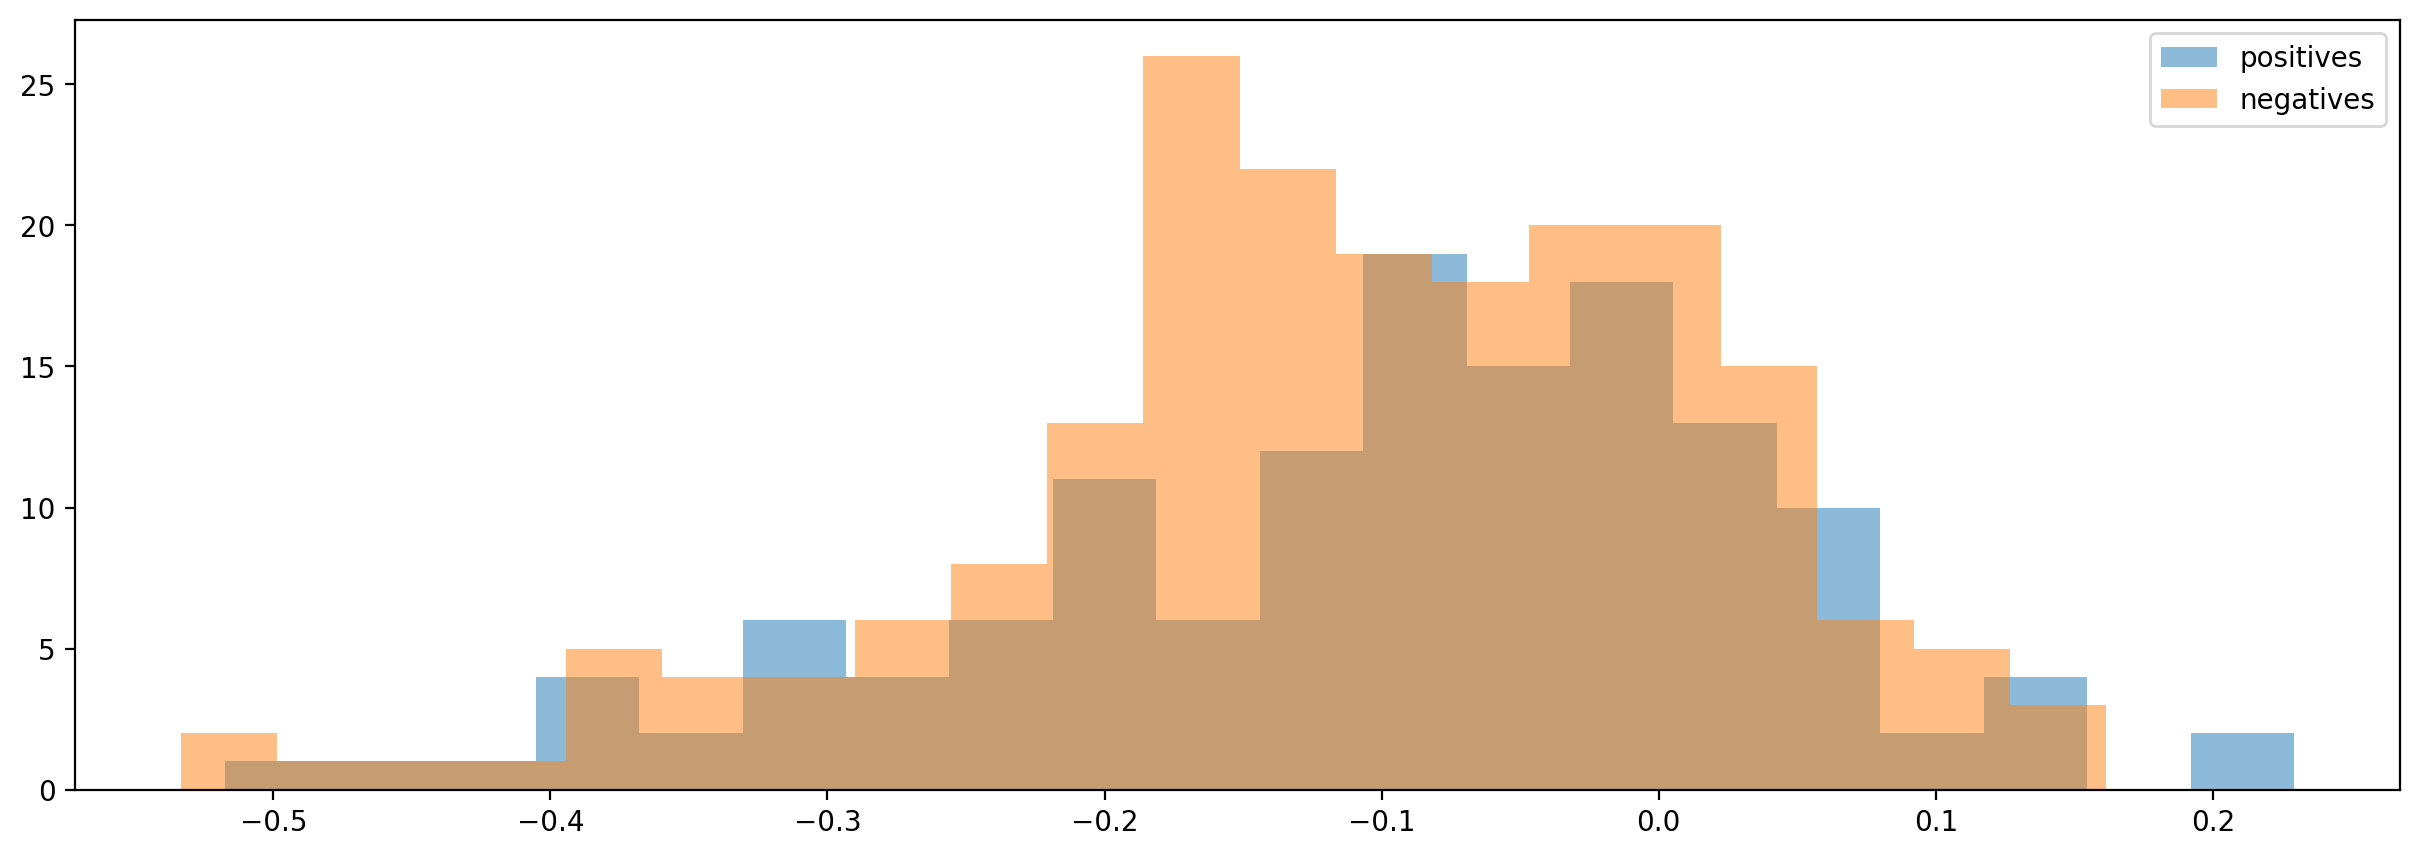

In [29]:
# make predictions by passing the embeddings through the classifier
preds = perch.predict(labels_val, batch_size=32, num_workers=num_workers)

# Note: if we already have the embeddings, we could have created epredictions much more quickly by running
# perch.network(torch.tensor(val_embeddings.float()))

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val == True], bins=20, alpha=0.5, label="positives")
plt.hist(preds[labels_val == False], bins=20, alpha=0.5, label="negatives")
plt.legend()

# calculate the area under the ROC score
roc_auc_score(labels_val.values, preds, average=None)

## Variations on training

OpenSoundscape also provides tools to generate embeddings for augmented variations of the input samples (`opensoundscape.shallow_classifier.augmented_embed()`), which could improve the classifiers performance and generalizability. See the transfer learning tutorial for further examples of this and other workflows. 

Here are a few other tools from the `shallow_classifiers` module to check out:

- augmented_embed(): generate embeddings for each sample multiple times, with stochastic augmentation on the audio clips

- fit_classifier_on_embeddings(): this function wraps together the embedding step with the classifier fitting step into a single operation, with support for generating augmented variations of training samples. It returns the embeddings and labels, in case you want to train additional classifiers on them

- MLPClassifier: this class creates a neural network with one or more fully connected layers. This object can be trained by passing it to quick_fit() or fit_classifier_on_embeddings(), or by running the MLPClassifier.fit() method (equivalent to quick_fit()). The input size should match the embedding size of the embedding model, and the output size should match the number of classes your model predicts on. 